In [6]:
import pandas as pd
google = pd.read_excel('https://raw.githubusercontent.com/ywchiu/tibame_tm/master/data/google_comments.xlsx',index_col=0)

In [7]:
google.head()

username  score  \
0                  倪依芙      5   
1                Mimi龍      4   
2                  林昌逸      1   
3                  林幸蓁      5   
4  台灣TAXI市區叫車禮車包車約拍找小鄭      5   

                                             comment  
0  起初找不到入口，還以為沒座位，但是原來入口在旁邊樓梯～座位區不大，但是料理很好吃～肉圓的醬微...  
1  聞名已久，今天特別來現場試試，目前改成點餐機點餐， ⋯⋯更多聞名已久，今天特別來現場試試，目...  
2          非常生氣服務員的態度😠服務很糟糕，麵都還沒吃完，一起身就把麵收走，擺明趕客人😡😡😡  
3  內用與外帶有不同的點餐方式內用須至店內使用機台點菜、輸入桌號並付款外帶好像只需在入口處點餐即...  
4  乾淨衛生，廁所很大在地下室，有免費飲料可以喝，拉麵愛好吃，麻辣豆腐不錯、肉粽不錯，目前吃過很...

In [8]:
google['score'].value_counts()

1    160
5    147
4     92
3     60
2     41
Name: score, dtype: int64

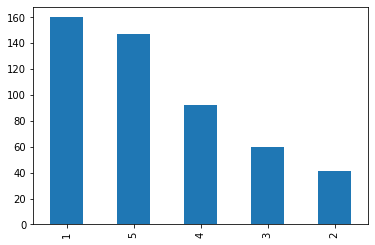

In [9]:
google['score'].value_counts().plot(kind = 'bar')

In [26]:
def convertscore(score):
    if score >= 4:
        return 'good'
    elif score == 3:
        return 'soso'
    else:
        return 'bad'

In [28]:
google['status'] = google['score'].map(lambda e : convertscore(e))

In [29]:
google.head()

username  score  \
0                  倪依芙      5   
1                Mimi龍      4   
2                  林昌逸      1   
3                  林幸蓁      5   
4  台灣TAXI市區叫車禮車包車約拍找小鄭      5   

                                             comment status  
0  起初找不到入口，還以為沒座位，但是原來入口在旁邊樓梯～座位區不大，但是料理很好吃～肉圓的醬微...   good  
1  聞名已久，今天特別來現場試試，目前改成點餐機點餐， ⋯⋯更多聞名已久，今天特別來現場試試，目...   good  
2          非常生氣服務員的態度😠服務很糟糕，麵都還沒吃完，一起身就把麵收走，擺明趕客人😡😡😡    bad  
3  內用與外帶有不同的點餐方式內用須至店內使用機台點菜、輸入桌號並付款外帶好像只需在入口處點餐即...   good  
4  乾淨衛生，廁所很大在地下室，有免費飲料可以喝，拉麵愛好吃，麻辣豆腐不錯、肉粽不錯，目前吃過很...   good

In [37]:
import jieba
corpus = []
tags = []
for idx, rec in google[google['status'].isin(['good','bad'])].iterrows():
    corpus.append(' '.join(jieba.cut(rec.get('comment'))))
    tags.append(rec.get('status'))

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/4f/nxxhtljx45b09spf0dj8mcrc0000gn/T/jieba.cache
Loading model cost 0.752 seconds.
Prefix dict has been built succesfully.


In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(corpus)

In [43]:
x = tfidf
y = tags

In [45]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [46]:
from sklearn.naive_bayes import MultinomialNB
clf1 = MultinomialNB(alpha = 0.01)
clf1.fit(train_x, train_y)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [47]:
from sklearn.svm import SVC
clf2 = SVC(kernel = 'linear')
clf2.fit(train_x, train_y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [49]:
pred_y = clf1.predict(test_x)

In [52]:
from sklearn.metrics import accuracy_score
accuracy_score(test_y, pred_y)

0.8863636363636364

In [54]:
from sklearn.metrics import confusion_matrix
print(clf1.classes_)
confusion_matrix(test_y, pred_y)

['bad' 'good']


array([[35,  5],
       [ 5, 43]])

In [55]:
features_ary = []
for word, bad_count, good_count in zip(vectorizer.get_feature_names(), clf1.feature_count_[0], clf1.feature_count_[1]):
    dic = {}
    dic['good_ratio'] = good_count/(bad_count + 1)
    dic['bad_ratio'] = bad_count / (good_count + 1)
    dic['good_cnt'] = good_count
    dic['bad_cnt'] = bad_count
    dic['word'] = word
    features_ary.append(dic)

In [56]:
import pandas as pd
features_df = pd.DataFrame(features_ary)

In [57]:
features_df.sort_values('good_ratio', ascending=False).head(10)

good_ratio  bad_ratio   good_cnt   bad_cnt word
772     4.371009   0.044135   5.654837  0.293714   好喝
12      4.353686   0.015449   4.739735  0.088672   24
839     4.353686   0.015449   4.739735  0.088672   小時
1831    4.284617   0.019280   4.760471  0.111061   親切
771     4.260324   0.166074  16.985919  2.987002   好吃
218     3.801249   0.123612   8.056882  1.119536   不錯
2174    3.554719   0.065548   4.938396  0.389251   飲料
380     3.458597   0.033600   4.044844  0.169504   免費
1685    3.253634   0.073720   4.595853  0.412529   美味
1000    3.140120   0.115345   5.491211  0.748727   意麵

In [58]:
features_df.sort_values('bad_ratio', ascending=False).head(10)

good_ratio  bad_ratio  good_cnt    bad_cnt word
1012    0.154955   3.766306  1.773726  10.446699   態度
1318    0.049185   3.144059  0.241113   3.902131   沒有
1180    0.052971   2.691366  0.228045   3.305118   普通
803     0.133453   2.642190  0.750798   4.625941   客人
213     0.019384   2.633355  0.074219   2.828799   不要
1558    0.049257   2.517408  0.197783   3.015309   知道
199     0.135743   2.451842  0.702303   4.173778   不會
2125    0.100767   2.360312  0.444277   3.408946   難吃
2068    0.000000   2.311808  0.000000   2.311808   重點
1793    0.000000   2.133261  0.000000   2.133261   蟑螂

In [59]:
pred_y = clf2.predict(test_x)

In [60]:
from sklearn.metrics import accuracy_score
accuracy_score(test_y, pred_y)

0.9090909090909091

In [61]:
from sklearn.metrics import confusion_matrix
print(clf1.classes_)
confusion_matrix(test_y, pred_y)

['bad' 'good']


array([[36,  4],
       [ 4, 44]])

In [62]:
features_ary = []
for word, bad_count, good_count in zip(vectorizer.get_feature_names(), clf1.feature_count_[0], clf1.feature_count_[1]):
    dic = {}
    dic['good_ratio'] = good_count/(bad_count + 1)
    dic['bad_ratio'] = bad_count / (good_count + 1)
    dic['good_cnt'] = good_count
    dic['bad_cnt'] = bad_count
    dic['word'] = word
    features_ary.append(dic)

In [63]:
import pandas as pd
features_df = pd.DataFrame(features_ary)

In [64]:
features_df.sort_values('good_ratio', ascending=False).head(10)

good_ratio  bad_ratio   good_cnt   bad_cnt word
772     4.371009   0.044135   5.654837  0.293714   好喝
12      4.353686   0.015449   4.739735  0.088672   24
839     4.353686   0.015449   4.739735  0.088672   小時
1831    4.284617   0.019280   4.760471  0.111061   親切
771     4.260324   0.166074  16.985919  2.987002   好吃
218     3.801249   0.123612   8.056882  1.119536   不錯
2174    3.554719   0.065548   4.938396  0.389251   飲料
380     3.458597   0.033600   4.044844  0.169504   免費
1685    3.253634   0.073720   4.595853  0.412529   美味
1000    3.140120   0.115345   5.491211  0.748727   意麵